In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.data import Dataset
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [2]:
RANDOM_SEED: int = 42

tf.random.set_seed(RANDOM_SEED)

The following code assumes you have already set up the local processed dataset as demonstrated in the last notebook. You can look at the `5_CNN_(Fingeralphabet).ipynb` sample solution to see how this was done. Here we will just load that dataset in.

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE: int = 16

In [4]:
# Load tensor dataset
train_ds = Dataset.load('../data/processed/train')
val_ds = Dataset.load('../data/processed/val')

# Batching and caching for performance optimization
train_ds: Dataset = (
    train_ds
    .batch(BATCH_SIZE, drop_remainder=True) #batches for prefetching
    .cache() #keeps in RAM for faster fetching, only do this if you have enough RAM
    .prefetch(buffer_size=AUTOTUNE) #speeds up training by pre-loading next batch while training
)
val_ds: Dataset = (
    val_ds
    .batch(BATCH_SIZE*2, drop_remainder=False) #can use larger batches for validation and they don't need to be the same size
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

2025-11-21 14:19:14.948514: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-21 14:19:14.948530: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-21 14:19:14.948536: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-21 14:19:14.948548: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-21 14:19:14.948556: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Multi-Part Models

Now that we have several different compontents to our model we can initialize them separately for better organization. The `name` parameter can help keep things organized.

In [5]:
data_augmentor = keras.Sequential([
    layers.RandomFlip("horizontal", seed=RANDOM_SEED),
    layers.RandomRotation(0.05, seed=RANDOM_SEED),      # was 0.1
    layers.RandomContrast(factor=0.2, seed=RANDOM_SEED) # was 1
], name='augmentation_block')

In [6]:
# --- Preprocessor ---
preprocessor = keras.Sequential([
    # Scaling pixel values to 0-1 range
    layers.Rescaling(1./255)
], name='preprocessor')

In [7]:
# --- Feature Extractor (also called "The Backbone") ---
feature_extractor = keras.Sequential([

    # Convolution Block 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Convolution Block 2
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Convolution Block 3
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Convolution Block 4
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2))
    
], name='feature_extractor')

In [8]:
# --- Classifier (also called "The Head") ---
classifier = keras.Sequential([

    layers.Flatten(),
    layers.Dropout(0.1),  # was 0.2 – slightly less dropout

    layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-4)  # ⬅️ L2 here
    ),
    layers.Dropout(0.3),  # was 0.5

    layers.Dense(
        3,
        activation='softmax',
        kernel_regularizer=regularizers.l2(1e-4)  # ⬅️ and here
    )
    
], name='classification_head')

In [9]:
# Combining the modules
model = keras.Sequential([
    layers.Input(shape=(256, 256, 3)),
    data_augmentor, #augmenting before scaling is more efficient
    preprocessor,
    feature_extractor,
    classifier
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_block (Sequential) │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocessor (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extractor (Sequential)  │ (None, 16, 16, 256)    │     1,126,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head             │ (None, 3)              │     8,389,123 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,515,203 (36.30 MB)

 Trainable params: 9,515,203 (36.30 MB)

 Non-trainable params: 0 (0.00 B)

## Training

We can use early stopping to automatically stop the training after the validation performance plateaus

In [10]:
es = EarlyStopping(
    monitor='val_loss',
    patience=10, #number of epochs of no improvement before training is stopped
    restore_best_weights=True #revert weights back to what they were before the plateau (undo overfitting)
)

Remember that because we already did the train-val split and batching, during `.fit` we change `validation_split=0.1` to `validation_data=val_ds` and we remove the `batch_size` parameter because the data is already batched.

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),  # was 'adam'
    loss='sparse_categorical_crossentropy', #for multiclass problems
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    epochs=60, #maximum epochs, may stop before this now that we have early stopping
    validation_data=val_ds,
    callbacks=[es]
)

Epoch 1/60


2025-11-21 14:19:21.081468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-11-21 14:19:21.086956: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.3388 - loss: 1.1274 - val_accuracy: 0.3478 - val_loss: 1.1185
Epoch 2/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.3750 - loss: 1.1142 - val_accuracy: 0.3913 - val_loss: 1.1102
Epoch 3/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.4309 - loss: 1.0954 - val_accuracy: 0.5362 - val_loss: 1.0608
Epoch 4/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.5230 - loss: 1.0322 - val_accuracy: 0.6377 - val_loss: 0.9580
Epoch 5/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.5872 - loss: 0.9223 - val_accuracy: 0.7246 - val_loss: 0.8201
Epoch 6/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.6711 - loss: 0.8077 - val_accuracy: 0.6957 - val_loss: 0.7801
Epoch 7/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.7155 - loss: 0.7108 - val_accuracy: 0.7101 - val_loss: 0.6979
Epoch 8/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.7368 - loss: 0.6290 - val_accuracy: 0.8116 - val_

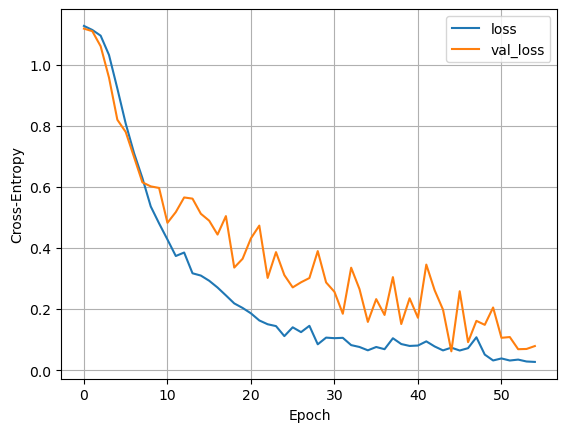

In [12]:
# Plotting loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.grid(True)

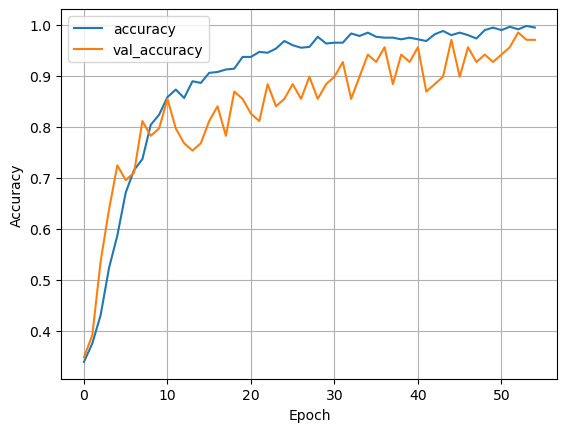

In [13]:
# Plotting accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

#### If you want to save your model after training you can run something like this:
model.save('../models/trained_model.keras')

In [14]:
import os

# make sure the folder exists (only adds a value, no structural change)
os.makedirs('../models', exist_ok=True)

model.save('../models/trained_model.keras')

In [15]:
# To load a saved model you can run this:
model = tf.keras.models.load_model('../models/trained_model.keras')

In [16]:
# Making predictions for the test set
test_probs: np.array = model.predict(val_ds)
# Converting probabilities into specific predictions
test_preds: np.array = np.argmax(test_probs, axis=1)

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step 

2025-11-21 14:24:52.715503: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [17]:
# Extracting y_test

# Unpack batch labels from val_ds
y_test_batches: list[np.ndarray] = [y for x, y in val_ds]
# Concatonate batches
y_test: np.ndarray = np.concatenate(y_test_batches)

2025-11-21 14:24:52.964128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
# Examining scores
class_names: list[str] = ['A', 'B', 'C']

print(classification_report(y_test, test_preds, target_names=class_names))

              precision    recall  f1-score   support

           A       1.00      0.96      0.98        24
           B       1.00      0.96      0.98        23
           C       0.92      1.00      0.96        22

    accuracy                           0.97        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69



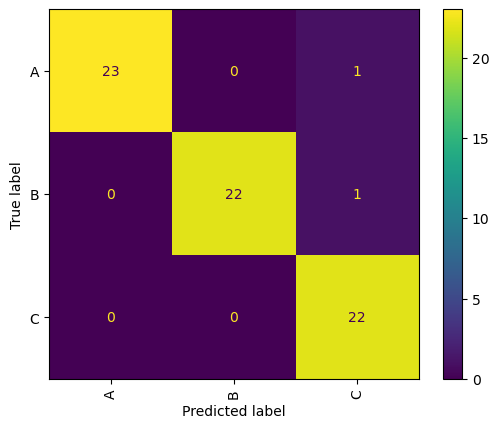

In [19]:
# Displaying confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=test_preds,
    display_labels=class_names,
    xticks_rotation='vertical'
);

Let's take a look at some of it's predictions

2025-11-21 14:24:53.027280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


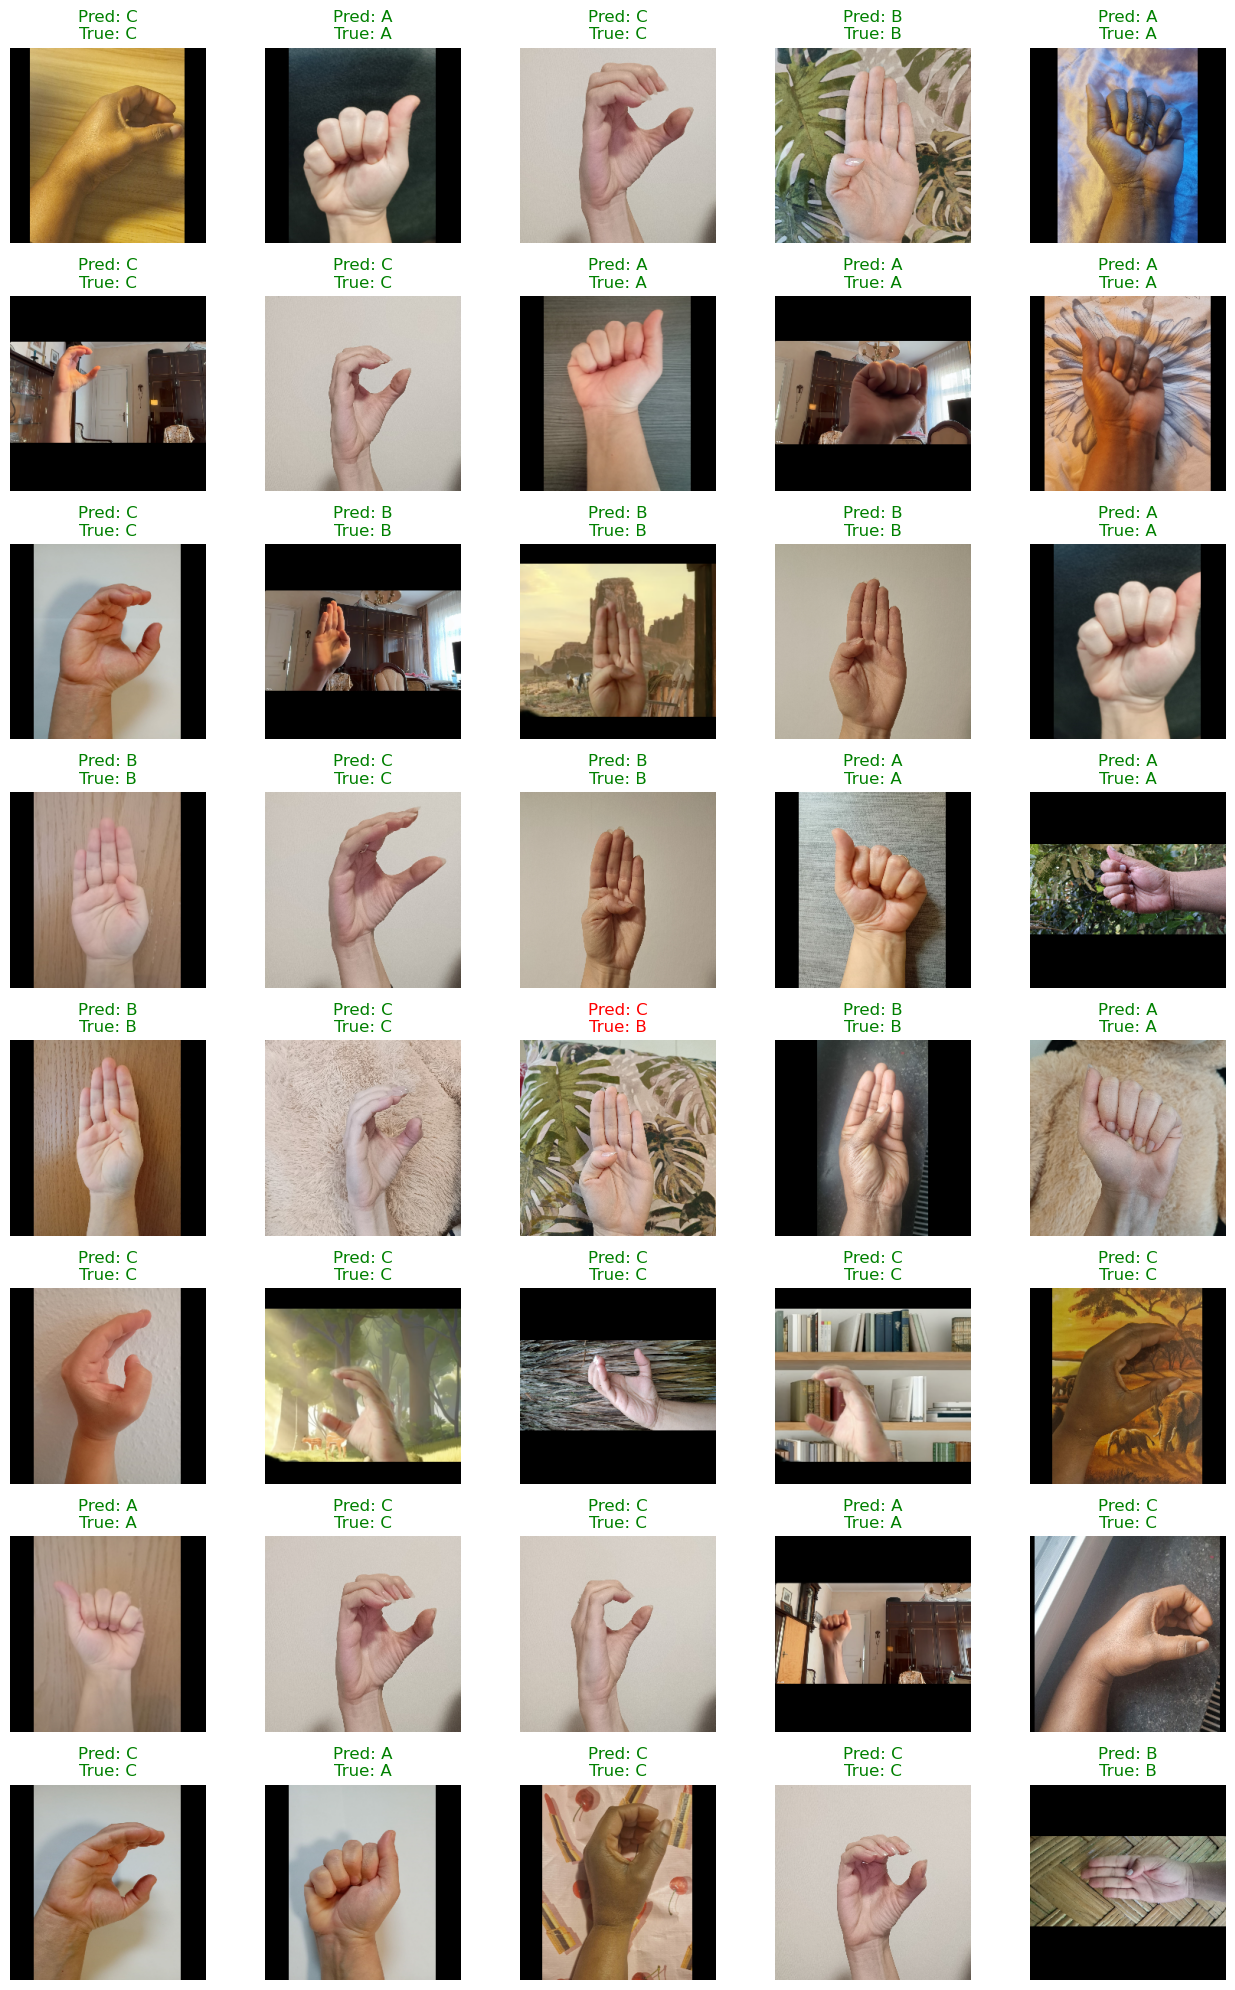

In [20]:
# Visualizing first 40 predictions
num_vis: int = 40

# Extracting images
batched_test_images: list[np.ndarray] = [X_batch for X_batch, y_batch in val_ds]
test_images: np.ndarray = np.concatenate(batched_test_images)

plt.figure(figsize=(int(num_vis/3),int(num_vis/2)))
columns=5

for i in range(num_vis):
    plt.subplot(int(num_vis/columns), columns, i+1)
    plt.imshow(test_images[i].astype('uint8'), cmap='gray')
    pred: int = test_preds[i]
    true: int = y_test[i]
    colour = 'green' if pred == true else 'red'
    plt.title(f'Pred: {class_names[pred]}\nTrue: {class_names[true]}', color=colour)
    plt.axis('off')

plt.tight_layout()
plt.show()